In [1]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.pipeline as skpipe
import celer as cel
import matplotlib.pyplot as plt
import statsmodels.api as sm

# dml dgps
from doubleml import datasets 
# this module
from aipyw import aipyw

In [2]:
aipyw?

Init signature: aipyw(y, w, X, omod, pmod, nf=5, pslb=None)
Docstring:     
Augmented Propensity Score Weighting for many discrete treatments.

Class to fit the Augmented IPW estimator using arbitrary scikit learners.
Extends the standard binary treatement estimator to K discrete treatments.
For details on influence function, see Cattaneo (2010) JoE.
Init docstring:
Initialise an aipyw class that holds data and models.

Args:
                                y (N X 1 Numpy Array): Response vector
                                w (N X 1 Numpy Array): Treatment vector (integer valued)
                                X (N X K Numpy Array): Covariate Matrix
                                omod (sklearn model object): Model object with .fit() and .predict() methods
                                pmod (sklearn model object): Model object with .fit() and .predict_proba() methods
                                nf (int, optional): Number of folds for cross-fitting. Interpreted as no cross-fit

In [3]:
aipyw.summary?

Signature: aipyw.summary(self, lb=None, critval=1.96)
Docstring:
summarise aipyw model fit. Computes causal contrasts between 0th level (assumed to be control)
        and each other value of w (i.e. K-1 treatment effects if w has K levels).

Args:
        lb (float, optional):                           Lower bound on propensity score for trimming.
                                                                                Defaults to None, which corresponds with ATE. Nonzero values no longer target ATE.
        critval (float, optional):                      Normal distribution critical values for confidencei intervals. Defaults to 1.96.
File:      ~/Desktop/code/00_causal/01aipyw/aipyw.py
Type:      function


# Demo

## generate some synthetic data with OVB

In [4]:
# make some data - true effect is 1
X, y, w = datasets.make_irm_data(1000, theta=1, return_type='array')

In [5]:
ppl = skpipe.Pipeline([
	('minmax', sklearn.preprocessing.MinMaxScaler()),
	('sieve',  sklearn.preprocessing.PolynomialFeatures(2)),
])
XX = ppl.fit_transform(X)

# naive estimate is biased
y[w==1].mean() - y[w==0].mean()

1.5450945424582043

Badly biased.

### AIPW

In [6]:
%%time
doubledouble = aipyw(y, w, XX,
                    # elastic net that also tunes mixing between lasso and ridge (with l1 ratio)
                    omod = cel.ElasticNetCV(l1_ratio= [.5, .7, .9],
                                            n_alphas=20, cv=5, n_jobs = 8),
                    # support vector classifier with rbf kernel - handles nonlinearities like a champ
                    pmod = sklearn.svm.SVC(gamma='auto', probability=True),
)
doubledouble.fit()
doubledouble.summary()

                                    ATE        SE  95% CI-LB  95% CI-UB
Treat level 1 - Treat level 0  1.088954  0.068103   0.955472   1.222436
CPU times: user 52.3 s, sys: 18.1 s, total: 1min 10s
Wall time: 45 s


Better.

Say we want to examine overlap by plotting pscores. In a procedural programming approach (as is typical when programming R functions, `s3` methods notwithstanding), one has to accommodate for this possibility by explicitly returning the pscores object, else the pscores are lost after the function call. With everything stored in the object, however, as long as the relevant attributes are exposed (i.e. not protected with the dunder `__`), we have the pscore to hand even though we didn't return anything.

(array([ 37.,  61.,  98., 115., 189., 206., 117.,  90.,  56.,  31.]),
 array([0.06653322, 0.15516855, 0.24380388, 0.3324392 , 0.42107453,
        0.50970986, 0.59834519, 0.68698051, 0.77561584, 0.86425117,
        0.9528865 ]),
 <BarContainer object of 10 artists>)

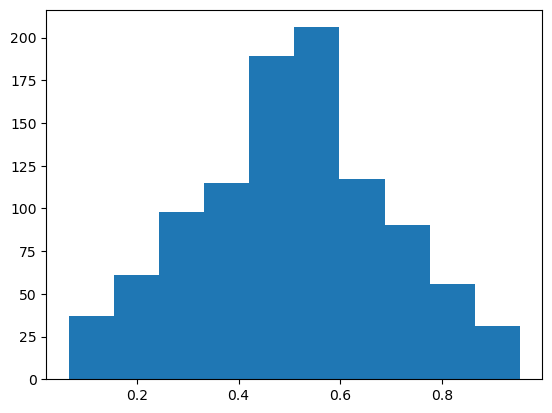

In [7]:
# pscores stored in .pi attribute; plot 2nd column because rows sum to one
plt.hist(doubledouble.pi[:, 1])